In [1]:
import pandas as pd
import numpy as np
from openclean.data.load import dataset
from openclean.pipeline import stream
from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
root = '../Dataset/'

files = [
    'DOB_NOW__Build___Approved_Permits.csv', 
    'DOB_Complaints_Received.csv', 
    'DOB_Violations.csv'
]

#Data column of Borough in different files
columns = [
    'Approved Date', 
    'Disposition Date',
    'ISSUE_DATE'
]

# Current Profile

In [3]:
# add all date columns to one dataframe, then generate the data profile
df = pd.DataFrame(columns=['Date'])
for file in files:
    path = root + file
    ds = dataset(path, encoding='utf-8')
    print("Loading... ", file)
    # rename all date cols to Date
    ds.rename(columns={'Approved Date': 'Date', 'Disposition Date': 'Date', 'ISSUE_DATE': 'Date'}, inplace=True)
    date = ds[['Date']]
    df = df.append(date)
print(len(df))

Loading...  DOB_NOW__Build___Approved_Permits.csv
Loading...  DOB_Complaints_Received.csv
Loading...  DOB_Violations.csv
5487839


In [4]:
df['Date'].value_counts()

                          294430
19950829                   46211
19970916                   35659
19980504                   35580
20020326                   32868
19970210                   32395
20000207                   31943
20010227                   31860
19990316                   31728
20030319                   31089
20040213                   29501
20111213                   29214
20050131                   27919
20070119                   27322
20080103                   27269
20090101                   26910
20091231                   26775
20060106                   26620
20140515                   22587
19930816                   21869
20180406                   19780
20150303                   19432
20130301                   18394
20170224                   16831
20191108                   16401
19940601                   15664
19930601                   15640
19930318                   15265
20151001                   15135
20170103                   14737
20161114  

# Apply Original Method

In [5]:
# For our original method, we used a specific regular expression reg to match the specific date format(M/D/Y)
# If the value in this data series can not match this regex, then we simply remove it
reg = "^(0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$"
def getNanIdx(df, column):
    series = df[column].isna()
    res = []
    idx = 0
    for serie in series:
        if serie:
            res.append(idx)
        idx += 1
    return res

def original_cleaning_method(df, column):
    idx = getNanIdx(df, column)
    df.loc[idx, column] = 'UNKNOWN'
    mask1 = df[column].str.match(reg)
    mask2 = df[column] == 'UNKNOWN'
    mask = mask1 | mask2
    df = df.loc[mask, :]
    affected_rows_count = len(idx) + len(df) - mask.sum()
    return df, affected_rows_count

def calc_precision_recall(remain_problems_rows_count, cleaned_rows_count):
    total = remain_problems_rows_count + cleaned_rows_count
    precision = (cleaned_rows_count - remain_problems_rows_count) / cleaned_rows_count if cleaned_rows_count != 0 else 0.0
    recall = (cleaned_rows_count - remain_problems_rows_count) / total if total != 0 else 0.0
    print(f'The precision value should be {precision} and the recall value should be {recall}')

# We only apply this method to the dataset DOB_Complaints_Received.csv
ds_full = pd.read_csv(root + files[1], low_memory=False)
ds_full, count = original_cleaning_method(ds_full, columns[1])

In [6]:
print(count)

294399


In [7]:
# Calculate the precision and call of the original method
# Based on the result of original cleaning method, we found that the total number of question rows should be 294399
# the number of question rows that have been modified is 294399, and the number of rows which still contain problems is 0
calc_precision_recall(0, count)

The precision value should be 1.0 and the recall value should be 1.0


In [8]:
# Save the reference data
df.to_csv('../Reference Data/original_version_date.csv', index=None)
ds_full.to_csv('../Reference Data/original_method_date.csv', index=None)

# Refined Method

In [9]:
df = pd.read_csv('../Reference Data/original_version_date.csv', low_memory=False)

In [10]:
# However, our original method can only work for date format (M/D/Y)
# For other data formats including '01/17/2019 03:32:00 PM' and '20191226', this method can not work
# Therefore, we update our regular expression to match those three types of date format
# This time, we mainly focus on the format outlier, eg. date format that can not match with any regular expression
reg = '(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/\d{4}|\d{4}(?:0[1-9]|1[0-2])(?:0[1-9]|[12][0-9]|3[01])|(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/\d{4} (?:0[1-9]|1[0-2])(?::[0-5][0-9]){2} [PA]M'
# Conver na and empty value to 'UNKNOWN'
df_clean = update(df, columns='Date', func=lambda x : 'UNKNOWN' if is_empty(x) else x)
df_clean.Date.fillna('UNKNOWN', inplace=True)
df_clean['Date'].value_counts()

UNKNOWN                   294430
19950829                   46211
19970916                   35659
19980504                   35580
20020326                   32868
19970210                   32395
20000207                   31943
20010227                   31860
19990316                   31728
20030319                   31089
20040213                   29501
20111213                   29214
20050131                   27919
20070119                   27322
20080103                   27269
20090101                   26910
20091231                   26775
20060106                   26620
20140515                   22587
19930816                   21869
20180406                   19780
20150303                   19432
20130301                   18394
20170224                   16831
20191108                   16401
19940601                   15664
19930601                   15640
19930318                   15265
20151001                   15135
20170103                   14737
20161114  

In [11]:
mask1 = df_clean.Date.str.match(reg)
mask2 = df_clean.Date == 'UNKNOWN'
mask = mask1 | mask2

In [12]:
df_clean.loc[~mask]

,Date
3279544,19505536
3520715,0000207
3600249,0306
3824849,000000
4062842,0808
4190778,0519
4541241,18110561
4594776,20067328
4633455,1230
4658283,0808


In [13]:
df_clean = df_clean.loc[mask]

In [14]:
# Then we want to find the cotent outlier by drawing pictures
def draw(vals, xlabel, ylabel, title, fontsize=15, rot=0, figsize=(30, 13)):
    vals = pd.Series(vals)
    vals.value_counts().plot(kind='bar', figsize=figsize, xlabel=xlabel, fontsize=fontsize, rot=rot)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

In [15]:
# Now we encapsulate our refined method in a function
def refined_method(df, column):
    reg = '(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/\d{4}|\d{4}(?:0[1-9]|1[0-2])(?:0[1-9]|[12][0-9]|3[01])|(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/\d{4} (?:0[1-9]|1[0-2])(?::[0-5][0-9]){2} [PA]M'
    df = update(df, columns=column, func=lambda x : 'UNKNOWN' if is_empty(x) else x)
    df[column].fillna('UNKNOWN', inplace=True)
    mask1 = df[column].str.match(reg)
    mask2 = df[column] == 'UNKNOWN'
    mask = mask1 | mask2
    df = df.loc[mask]
    return df

## For dataset DOB_NOW__Build___Approved_Permits.csv

In [16]:
df = pd.read_csv(root + files[0], low_memory=False)

In [17]:
# Apply refined method to this dataset
df = refined_method(df, columns[0])

In [18]:
# Extract years, months and days
years = []
months = []
days = []
for date in df[columns[0]]:
    if date == 'UNKNOWN':
        continue
    MDY = date.split()[0]
    strs = MDY.split('/')
    month = int(strs[0])
    day = int(strs[1])
    year = int(strs[2])
    months.append(month)
    days.append(day)
    years.append(year)

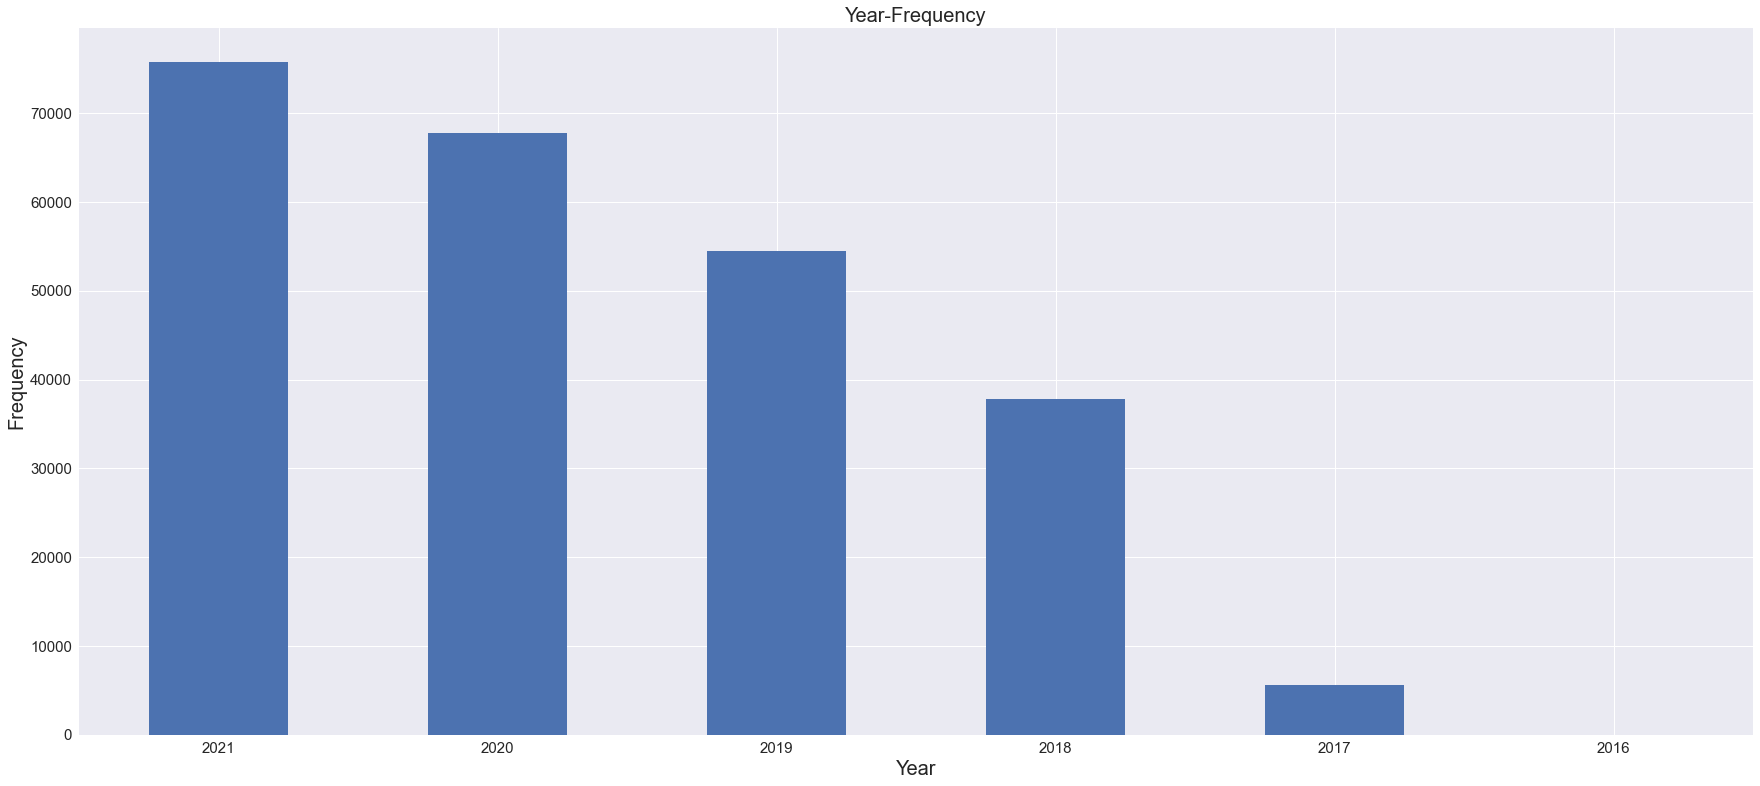

In [19]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency')

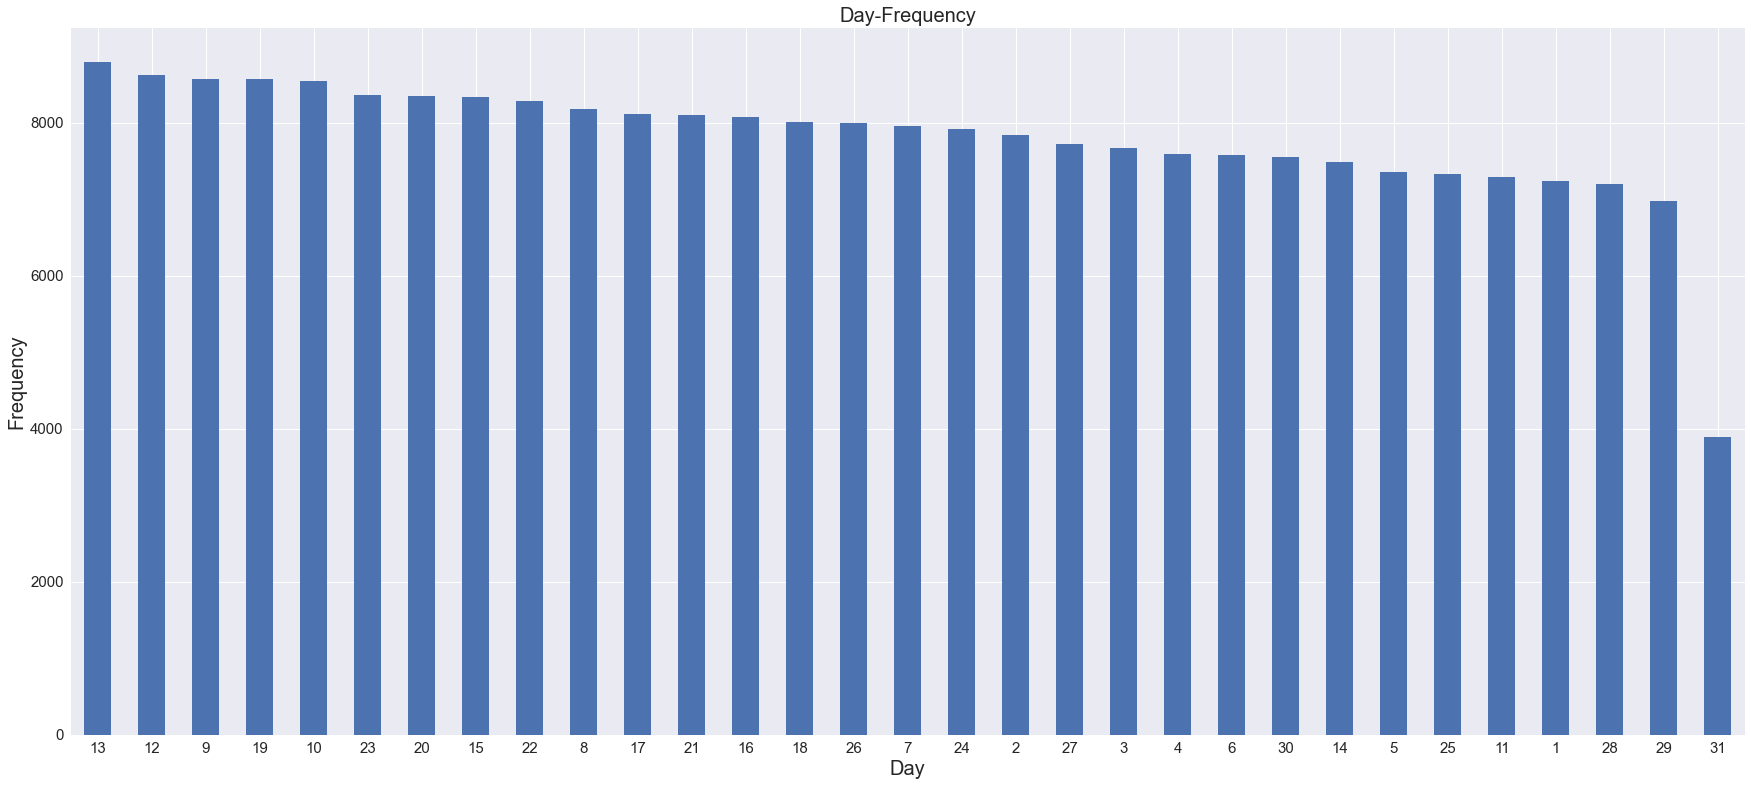

In [20]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

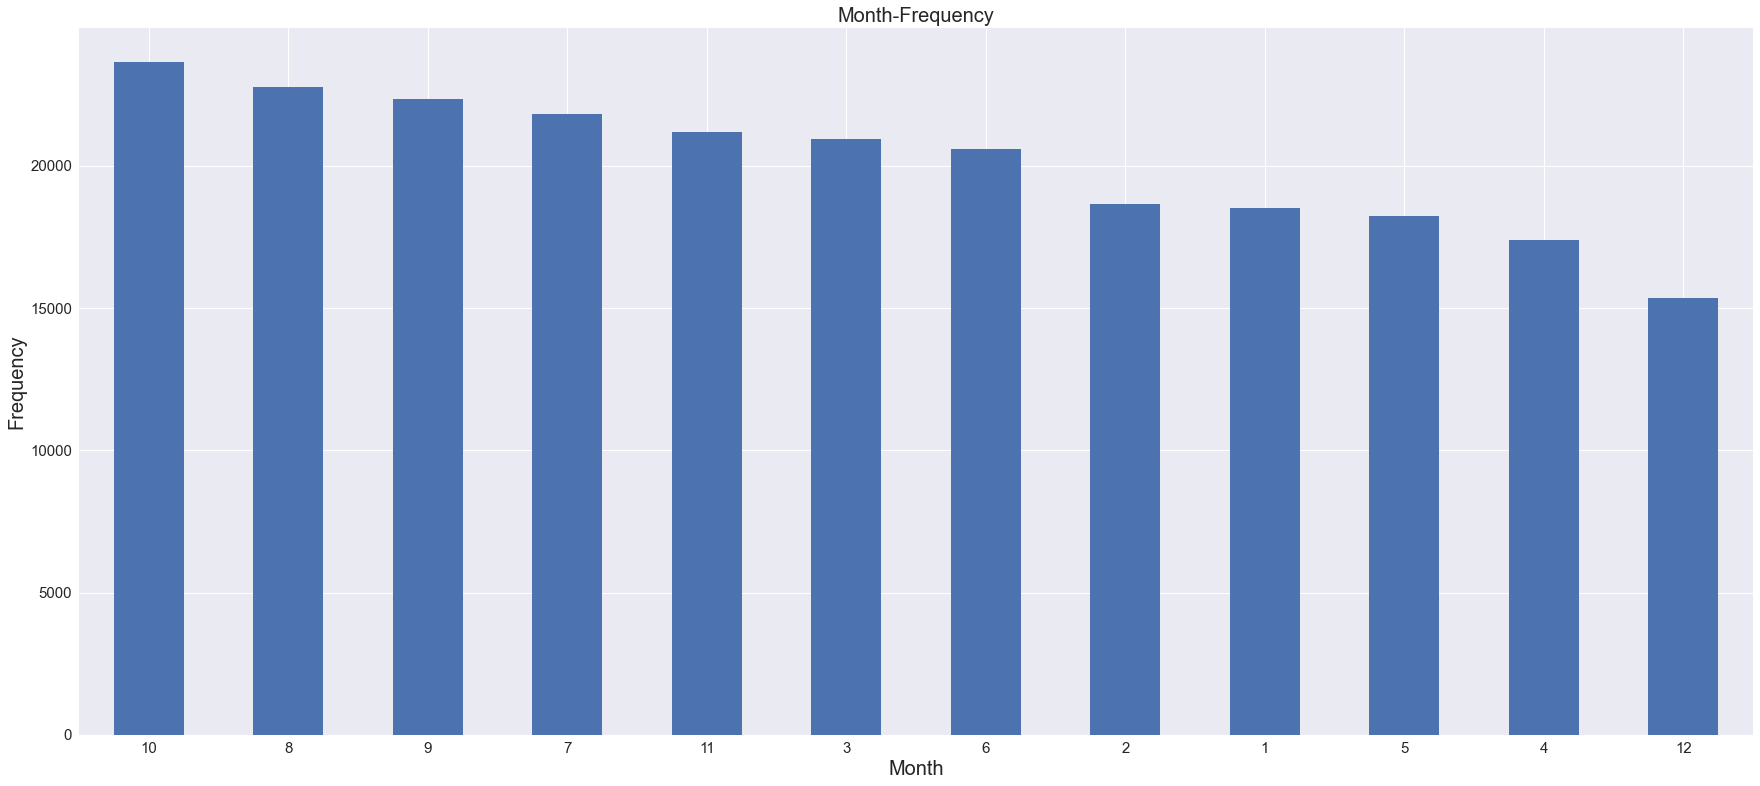

In [21]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')

## For dataset DOB_Complaints_Received.csv 

In [22]:
df = pd.read_csv(root + files[1], low_memory=False)

In [23]:
# Apply refined method to this dataset
df = refined_method(df, columns[1])

In [24]:
# Extract years, months and days
years = []
months = []
days = []
for date in df[columns[1]]:
    if date == 'UNKNOWN':
        continue
    strs = date.split('/')
    month = int(strs[0])
    day = int(strs[1])
    year = int(strs[2])
    months.append(month)
    days.append(day)
    years.append(year)

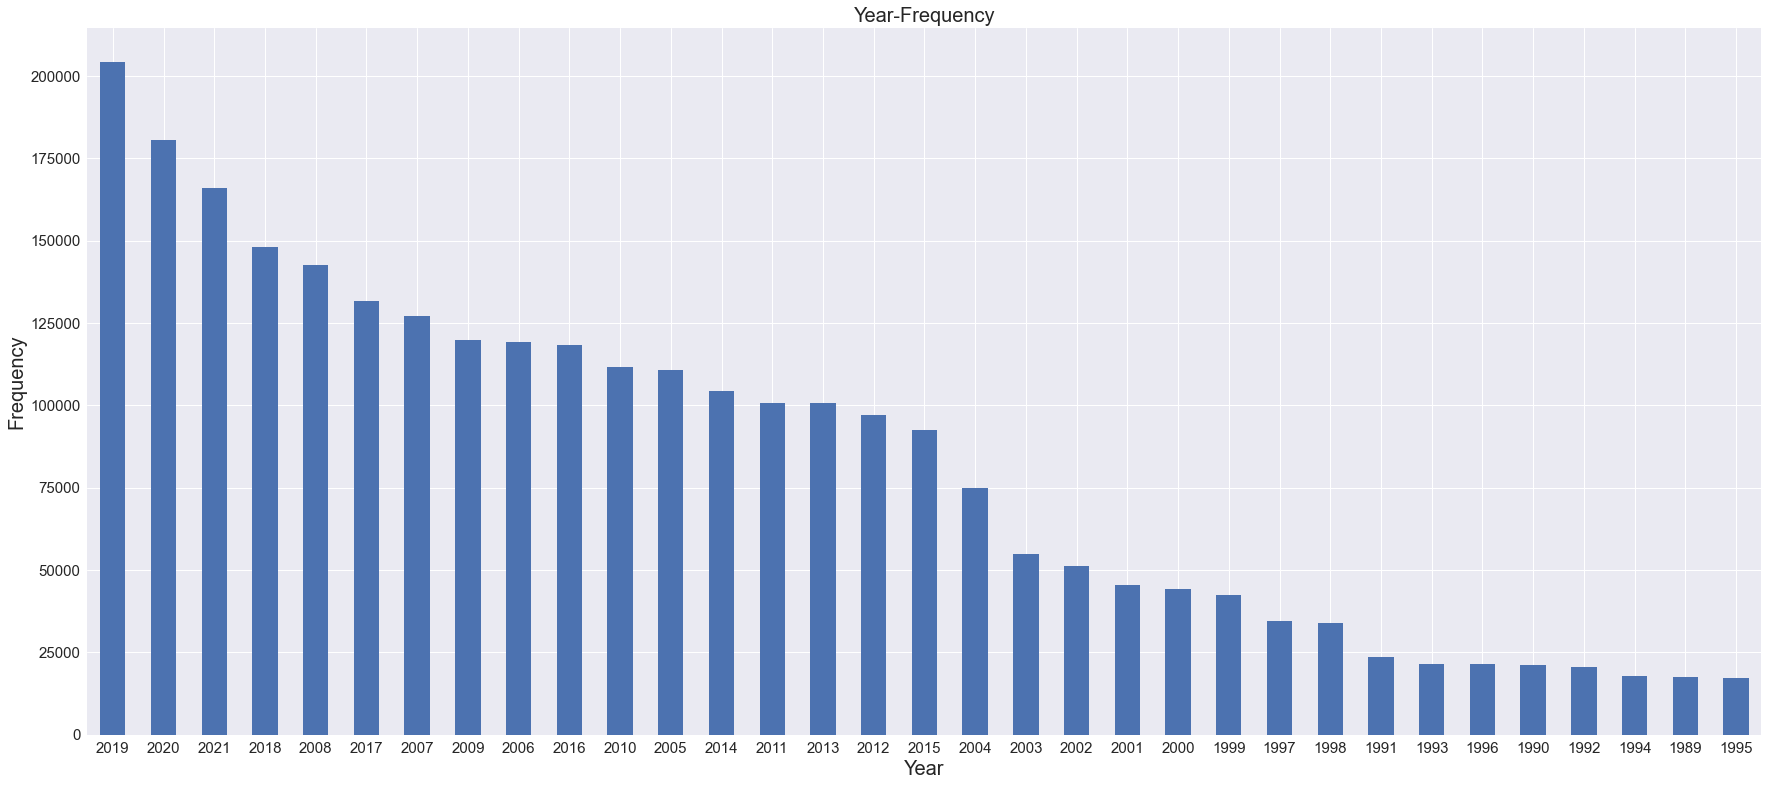

In [25]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency')

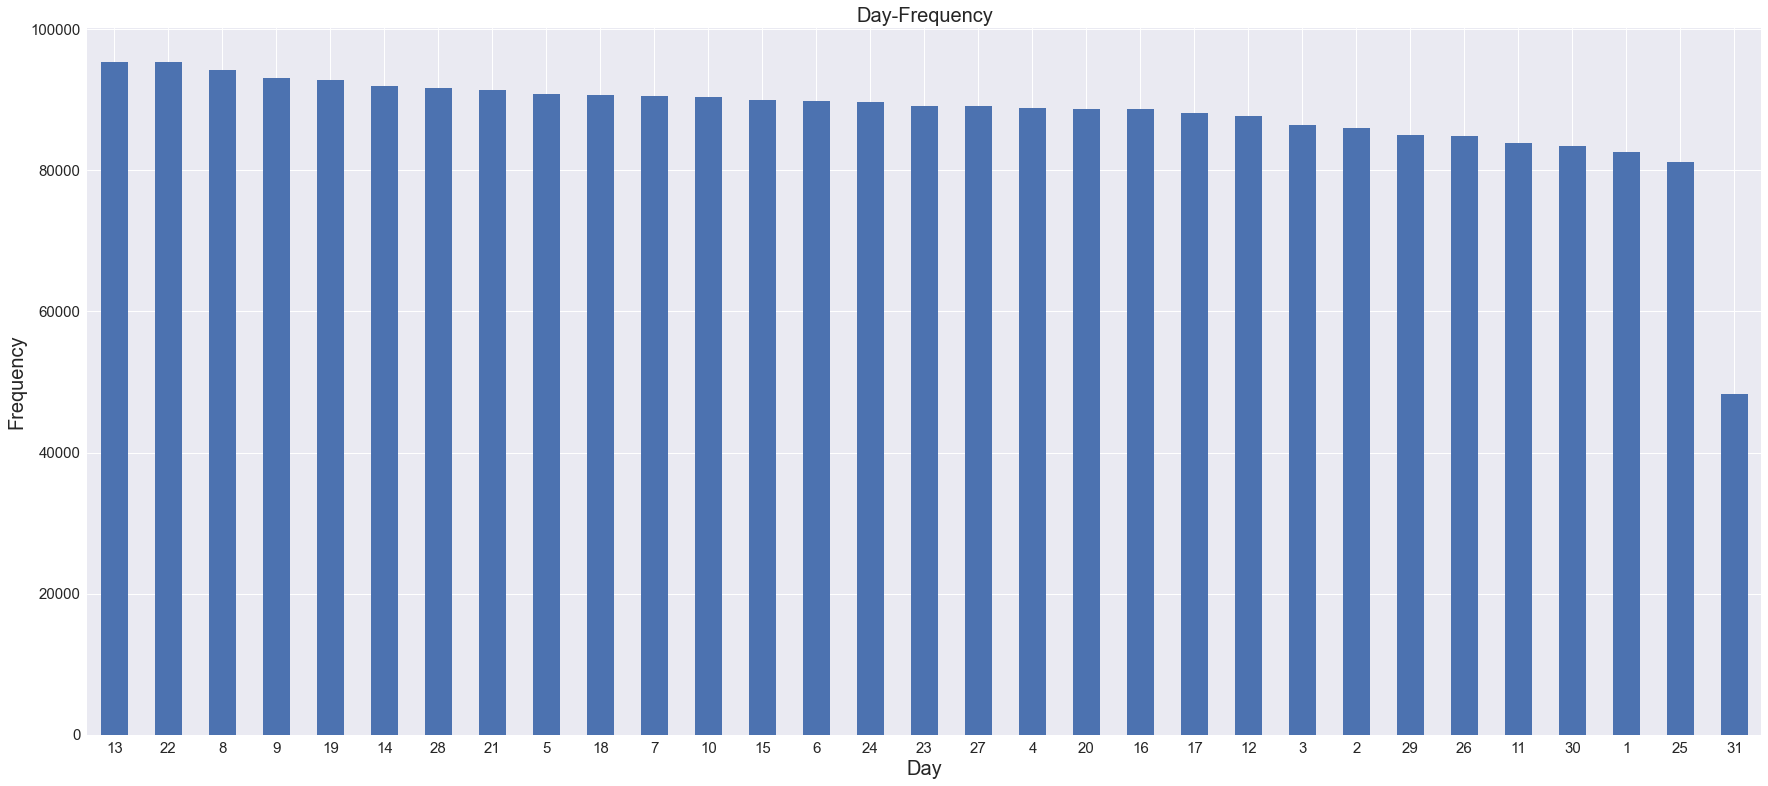

In [26]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

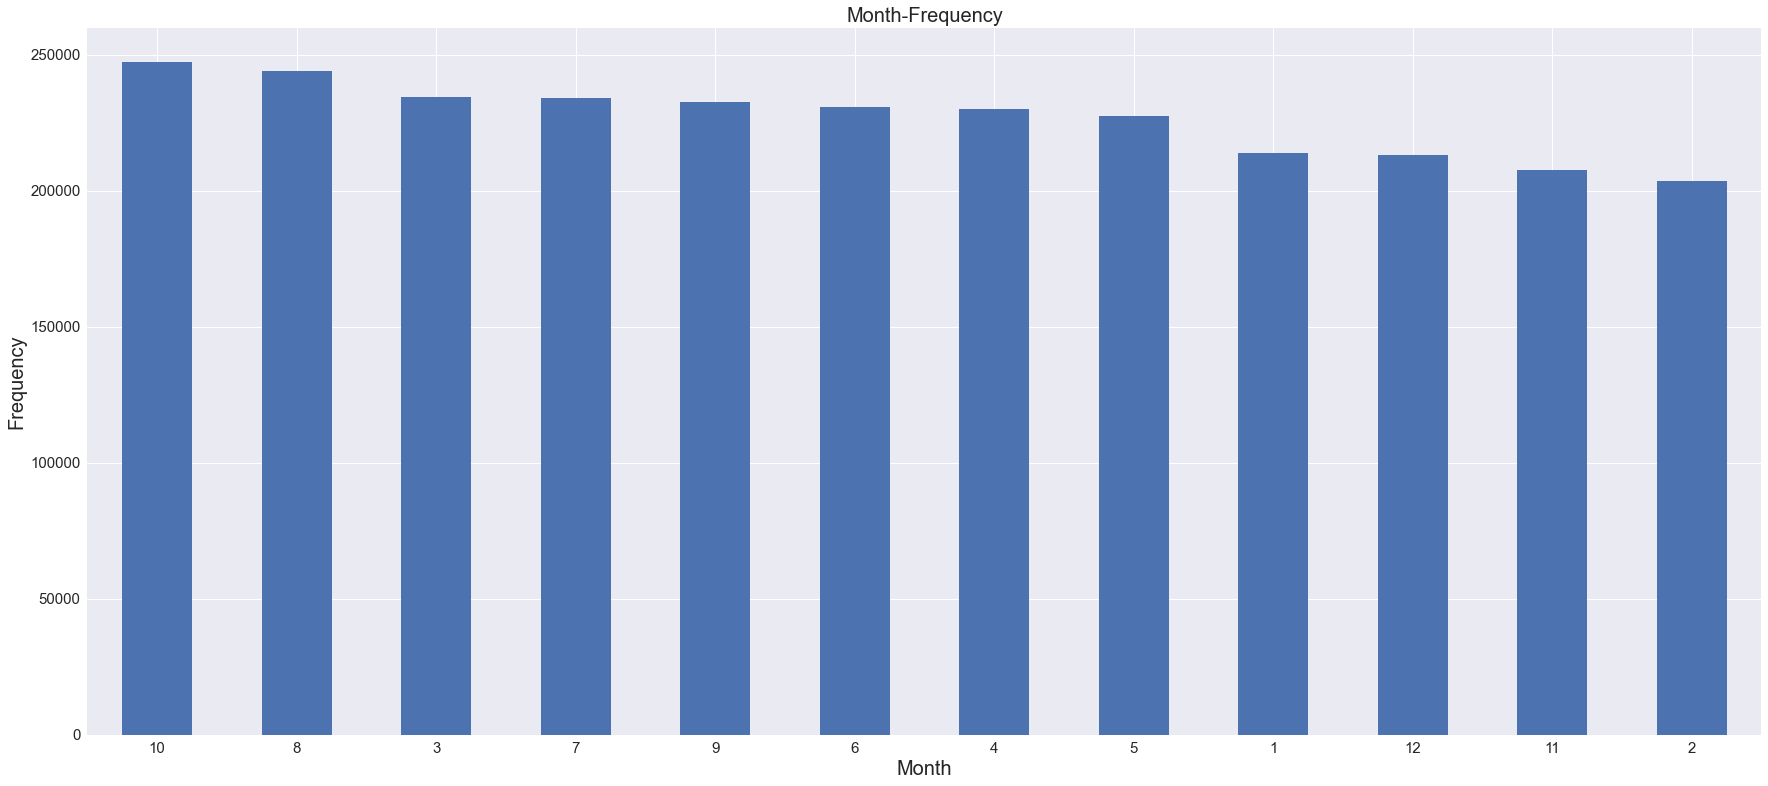

In [27]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')

## For dataset DOB_Violations.csv

In [28]:
df = pd.read_csv(root + files[2], low_memory=False)

In [29]:
# Apply refined method to this dataset
df = refined_method(df, columns[2])

In [30]:
# Extract years, months and days
years = []
months = []
days = []
for date in df[columns[2]]:
    if date == 'UNKNOWN':
        continue
    year = date[0:4]
    month = date[4:6]
    day = date[6:]
    months.append(month)
    days.append(day)
    years.append(year)

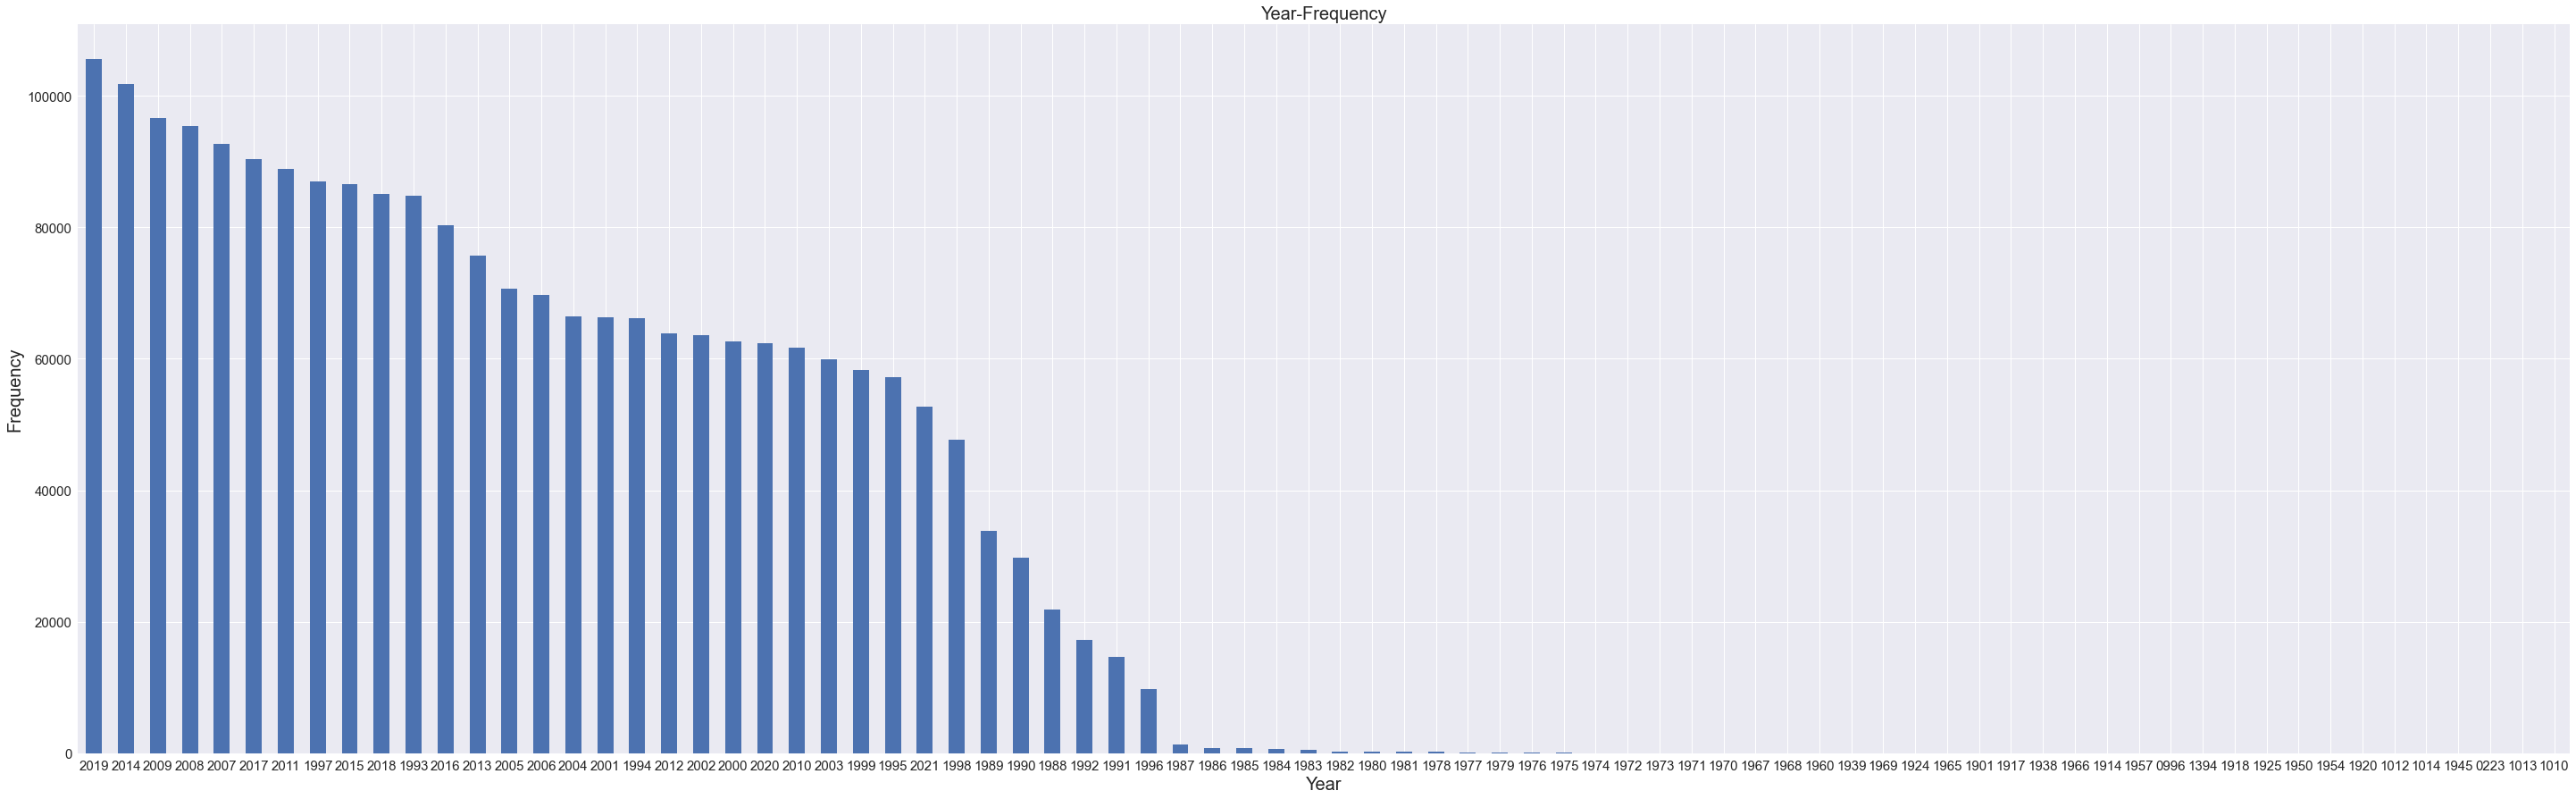

In [31]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency', figsize=(50, 15))

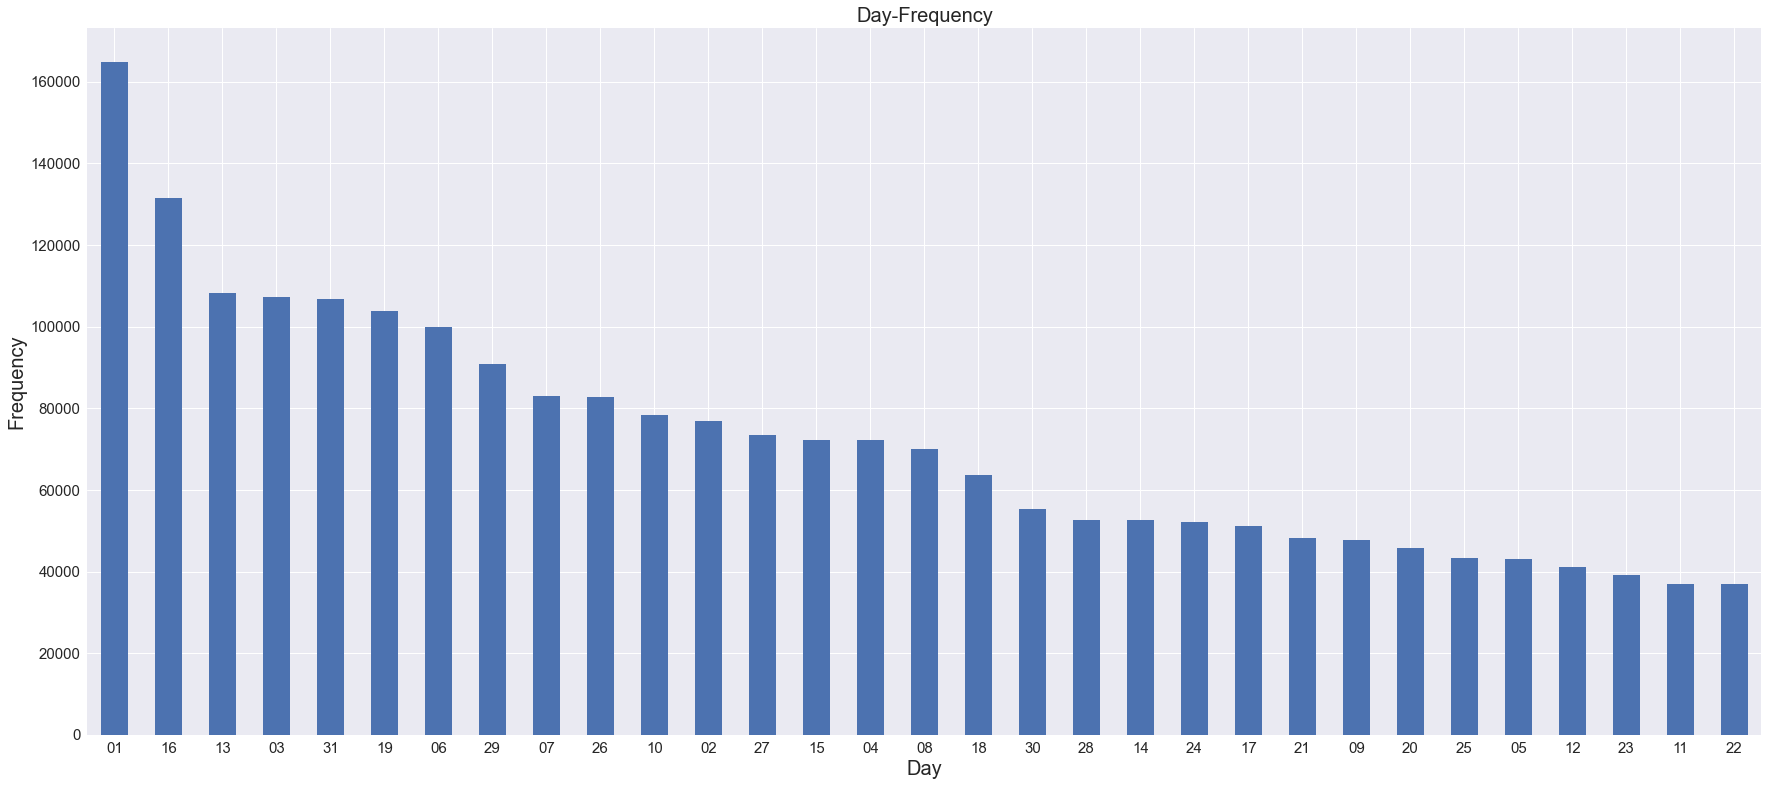

In [32]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

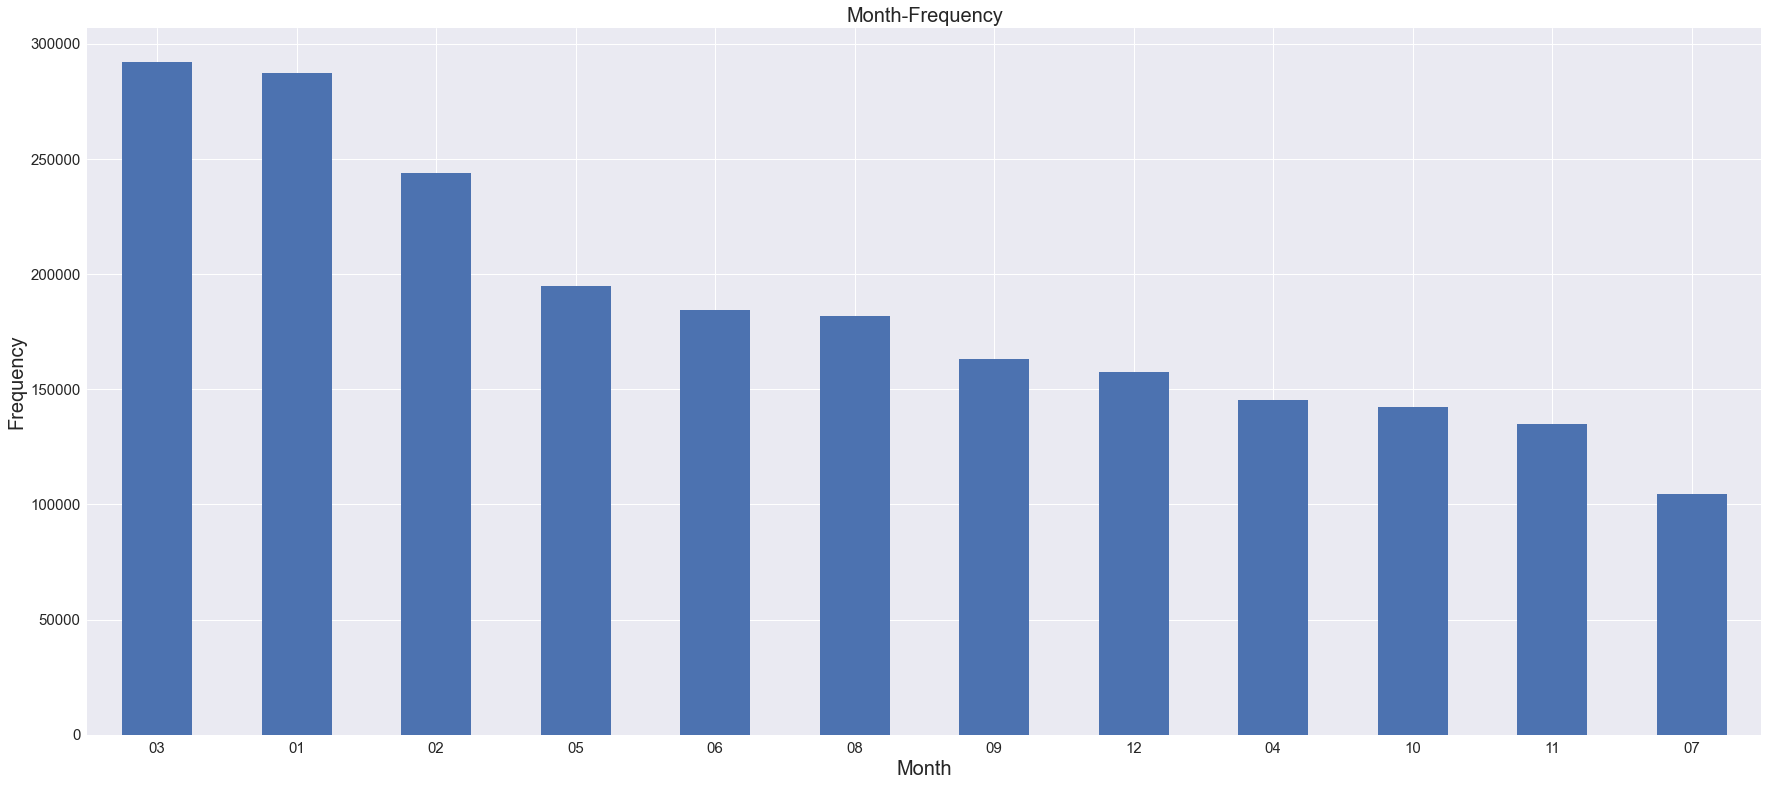

In [33]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')

### We found that in dataset DOB_Violations.csv, there are several years who is obviously outlier, including 1010, 1013. Thus, we decided to remove those outliers by updating our regular expressions

In [34]:
# Here is our final refined method
def final_refined_method(df, column):
    reg = '(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/(?:19[0-9][0-9]|20[0-2][0-9])|(?:0[1-9]|1[0-2])/(?:0[1-9]|[12][0-9]|3[01])/(?:19[0-9][0-9]|20[0-2][0-9]) (?:0[1-9]|1[0-2])(?::[0-5][0-9]){2} [PA]M|(?:19[0-9][0-9]|20[0-2][0-9])(?:0[1-9]|1[0-2])(?:0[1-9]|[12][0-9]|3[01])'
    df = update(df, columns=column, func=lambda x : 'UNKNOWN' if is_empty(x) else x)
    df[column].fillna('UNKNOWN', inplace=True)
    mask1 = df[column].str.match(reg)
    mask2 = df[column] == 'UNKNOWN'
    mask = mask1 | mask2
    df = df.loc[mask]
    return df

# Apply final refined method to each dataset

## For dataset DOB_NOW__Build___Approved_Permits.csv

In [35]:
df = pd.read_csv(root + files[0], low_memory=False)
# Apply refined method to this dataset
df = final_refined_method(df, columns[0])
df.to_csv('../Resultset//Date_res_1.csv')
# Extract years, months and days
years = []
months = []
days = []
for date in df[columns[0]]:
    if date == 'UNKNOWN':
        continue
    MDY = date.split()[0]
    strs = MDY.split('/')
    month = int(strs[0])
    day = int(strs[1])
    year = int(strs[2])
    months.append(month)
    days.append(day)
    years.append(year)

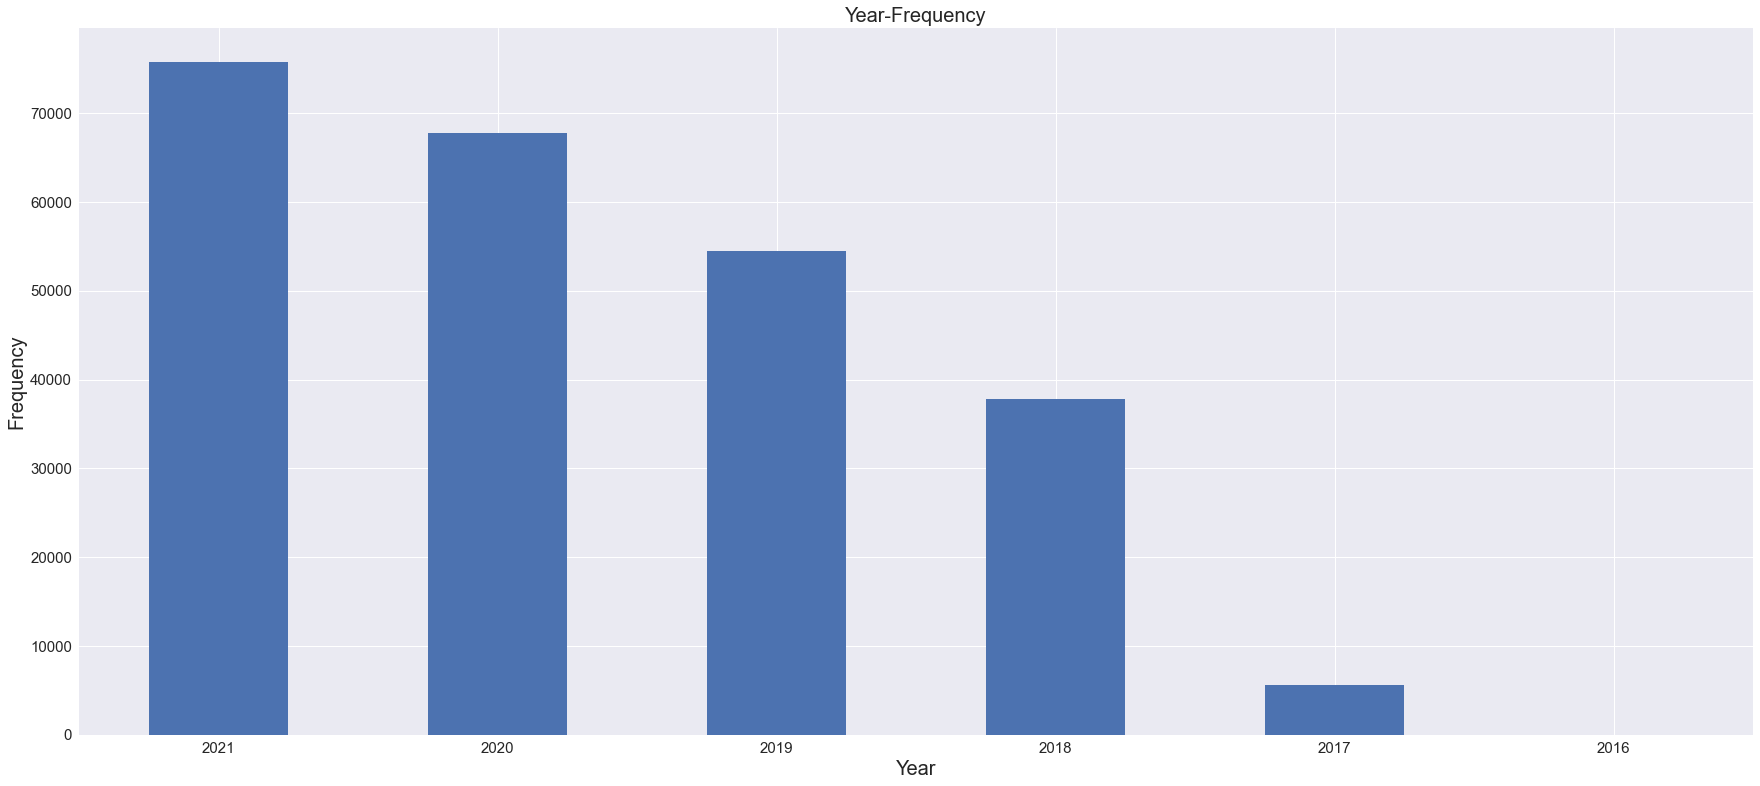

In [36]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency')

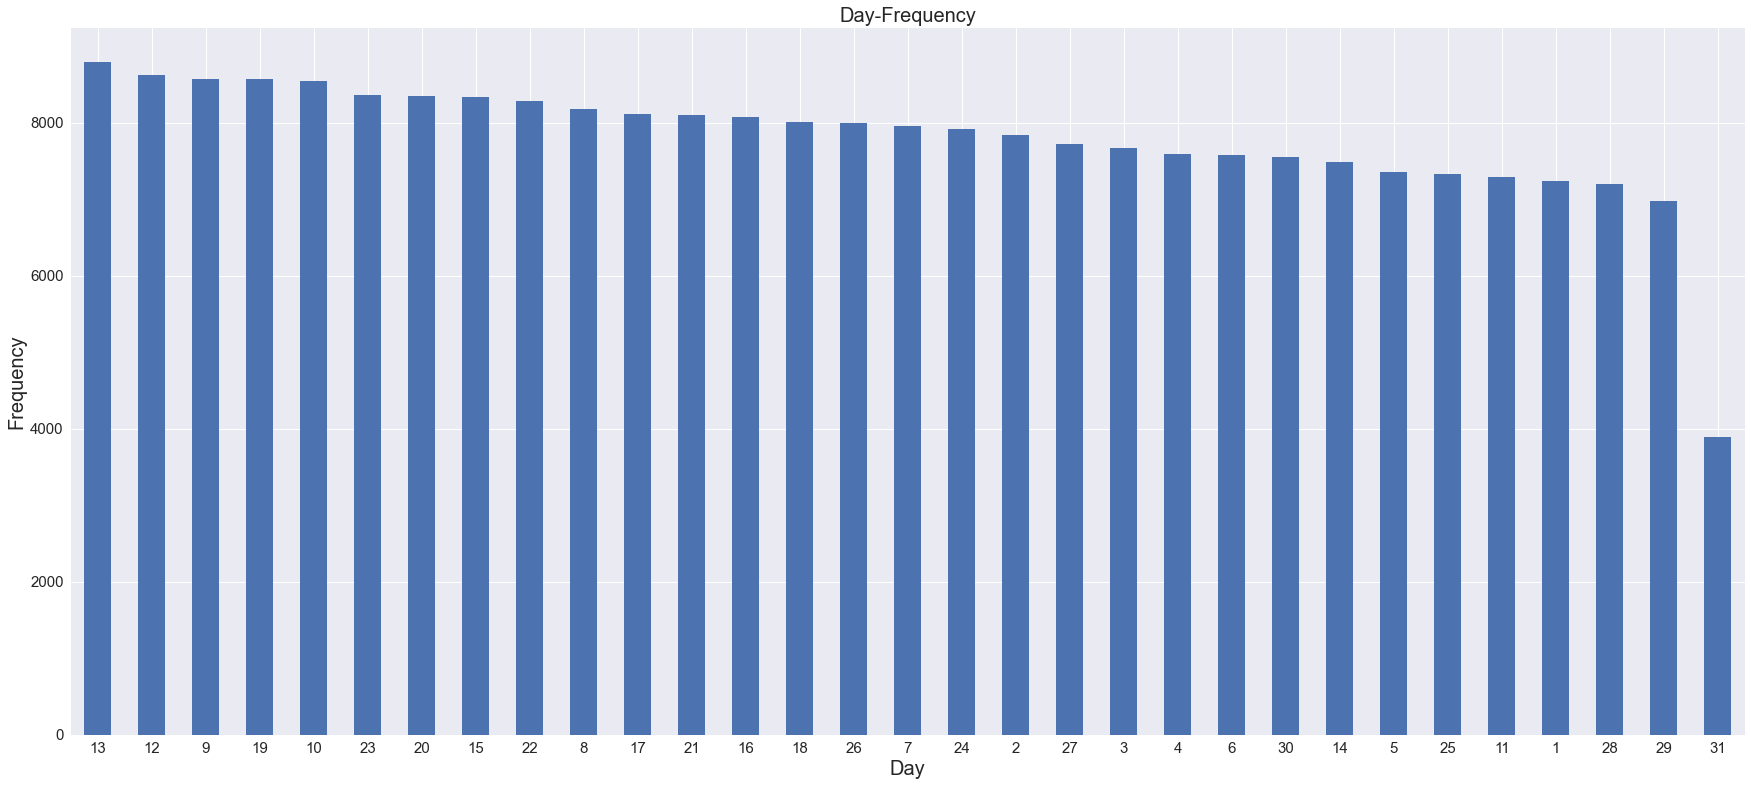

In [37]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

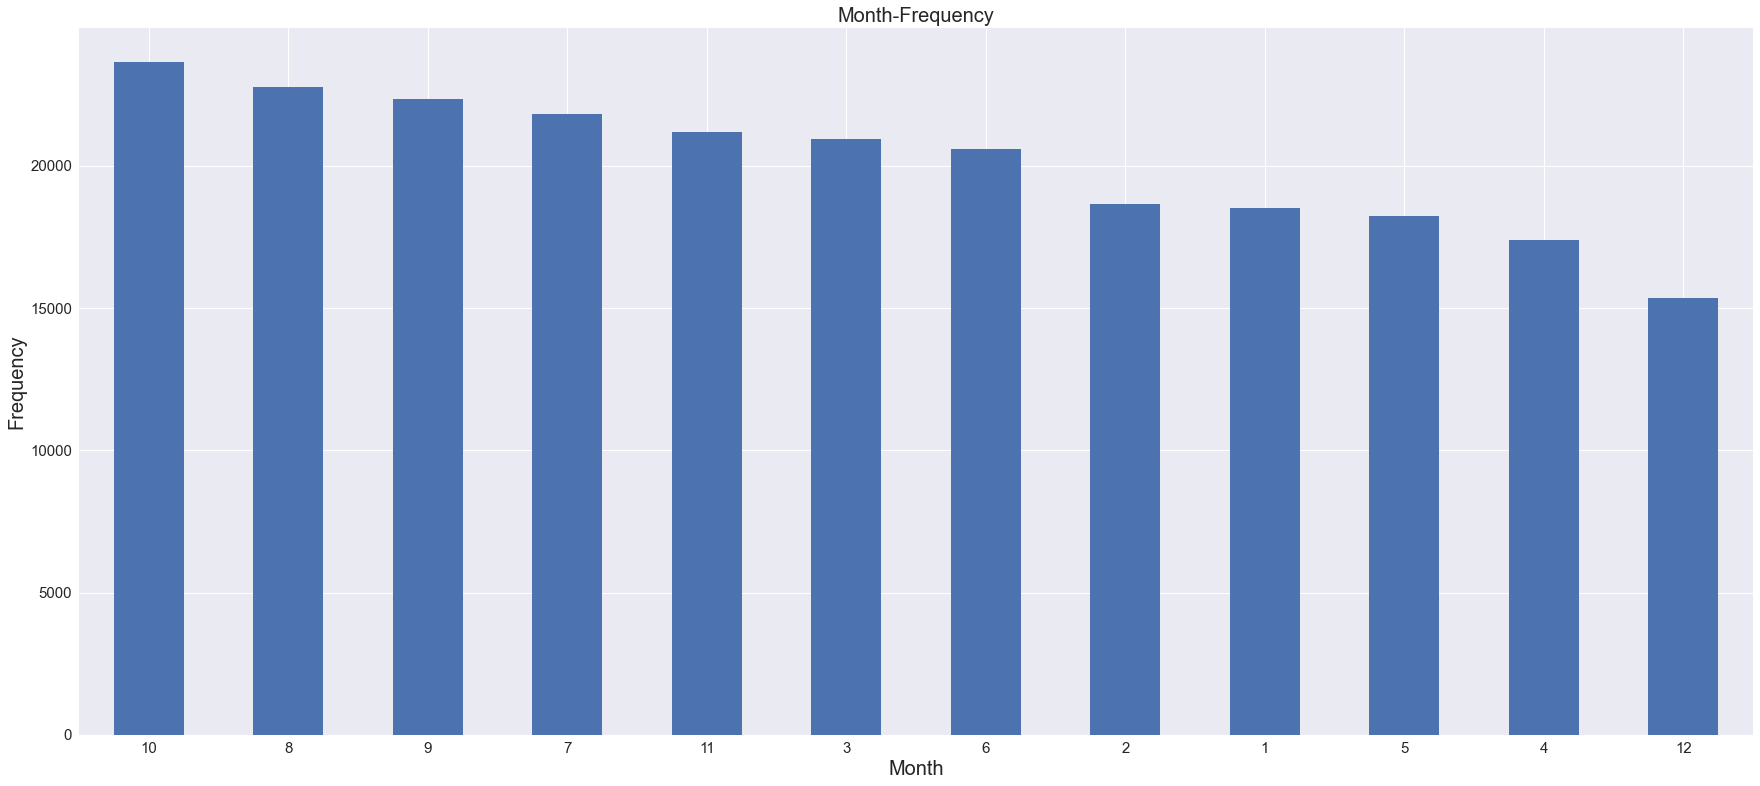

In [38]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')

## For dataset DOB_Complaints_Received.csv 

In [39]:
df = pd.read_csv(root + files[1], low_memory=False)
# Apply refined method to this dataset
df = final_refined_method(df, columns[1])
df.to_csv('../Resultset//Date_res_2.csv')
# Extract years, months and days
years = []
months = []
days = []
for date in df[columns[1]]:
    if date == 'UNKNOWN':
        continue
    strs = date.split('/')
    month = int(strs[0])
    day = int(strs[1])
    year = int(strs[2])
    months.append(month)
    days.append(day)
    years.append(year)

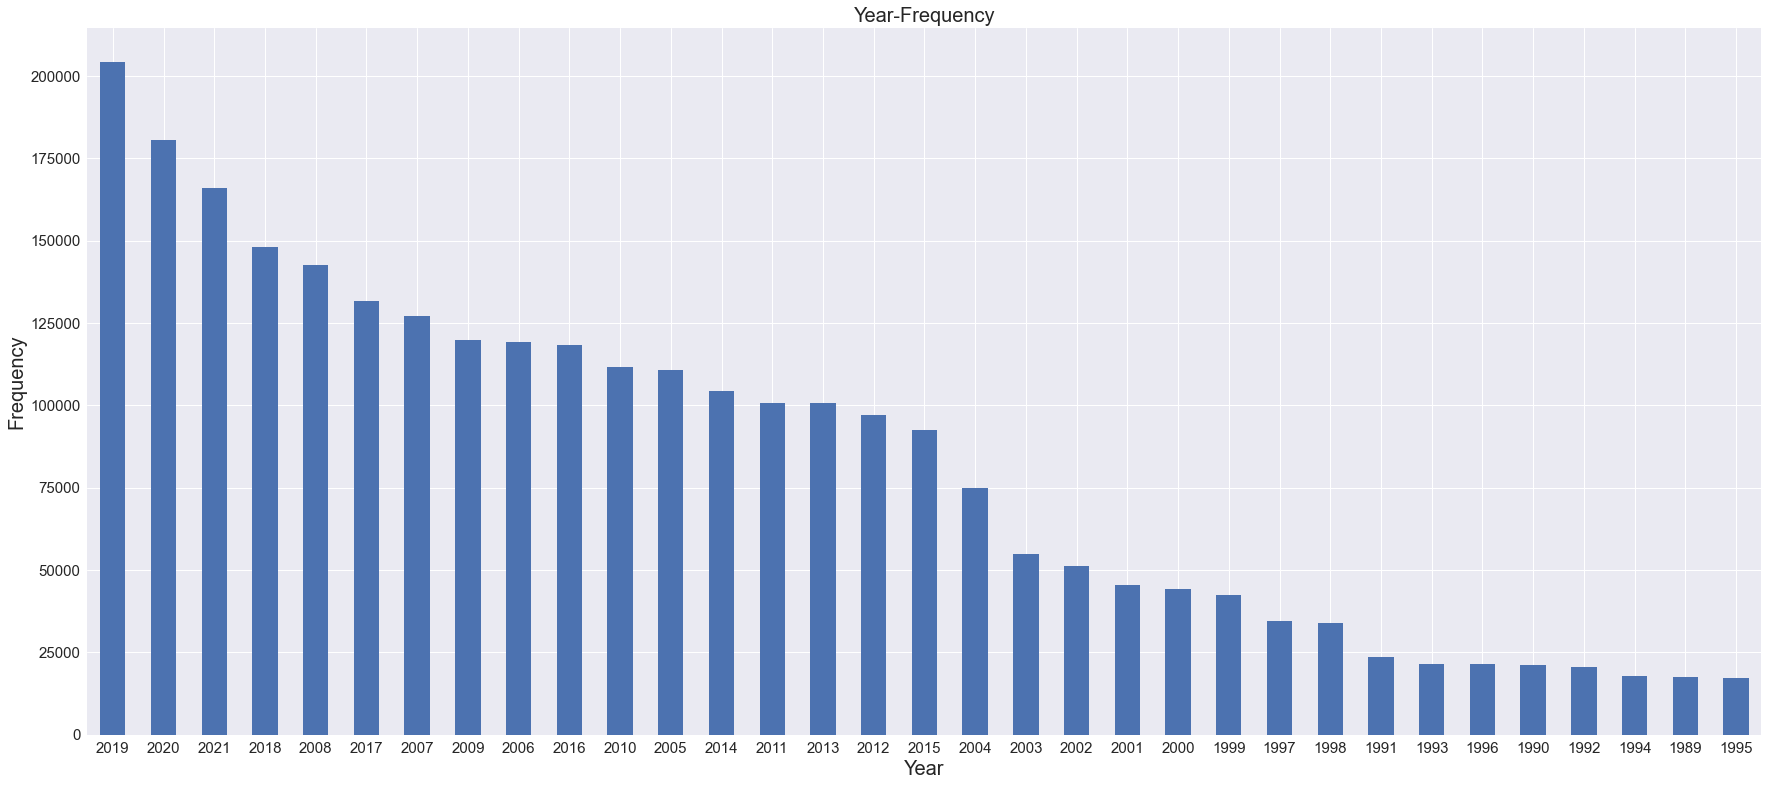

In [40]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency')

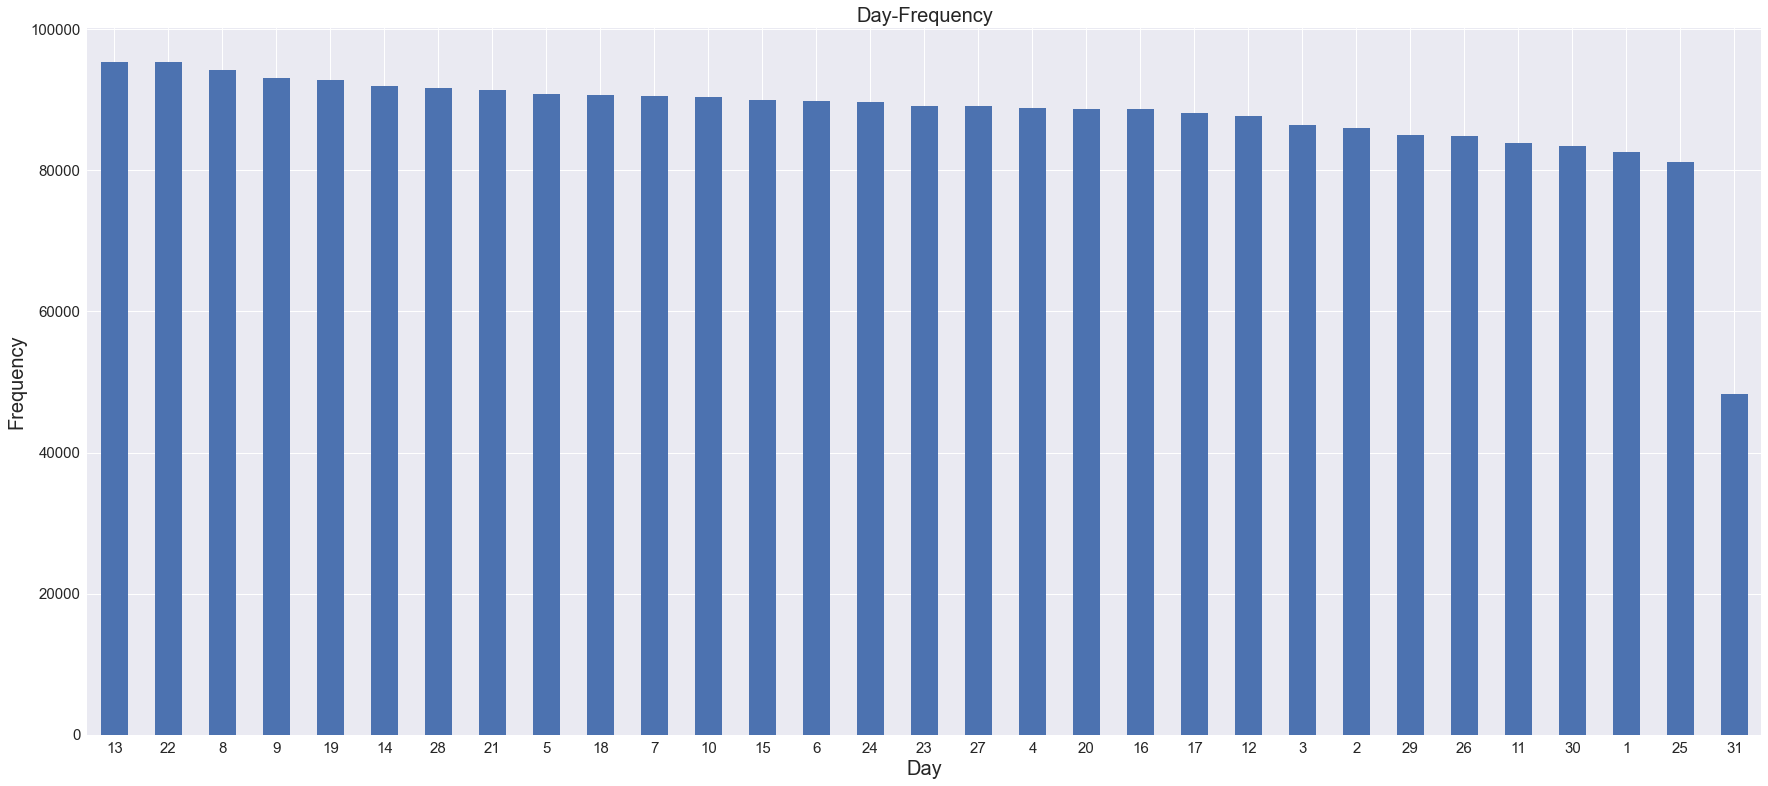

In [41]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

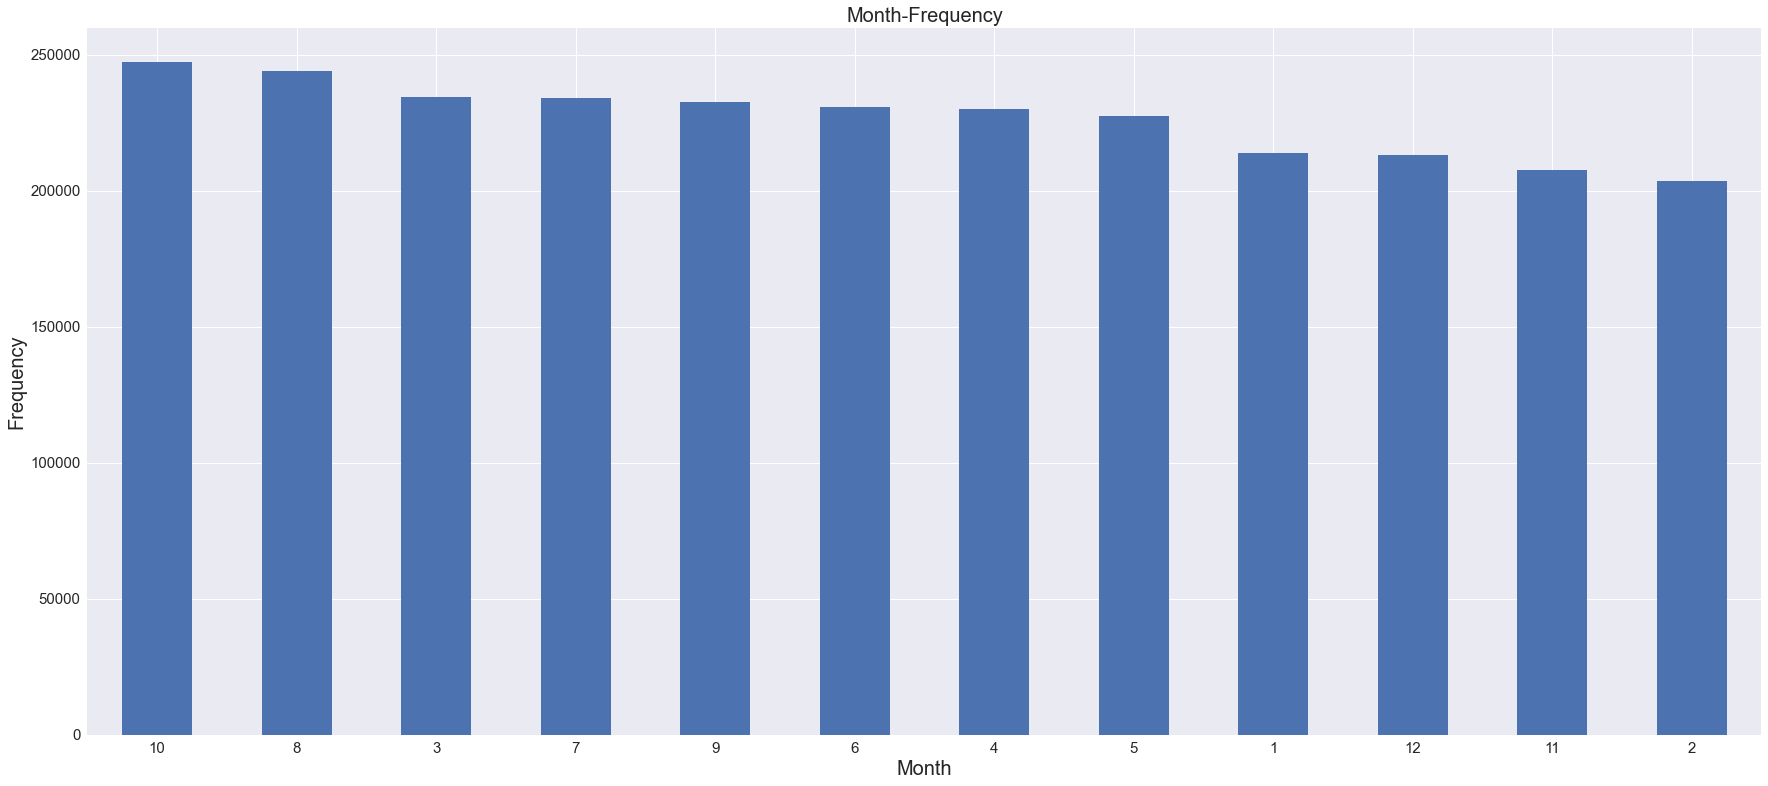

In [42]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')

## For dataset DOB_Violations.csv

In [43]:
# Extract years, months and days
df = pd.read_csv(root + files[2], low_memory=False)
# Apply refined method to this dataset
df = final_refined_method(df, columns[2])
df.to_csv('../Resultset//Date_res_3.csv')
years = []
months = []
days = []
for date in df[columns[2]]:
    if date == 'UNKNOWN':
        continue
    year = date[0:4]
    month = date[4:6]
    day = date[6:]
    months.append(month)
    days.append(day)
    years.append(year)

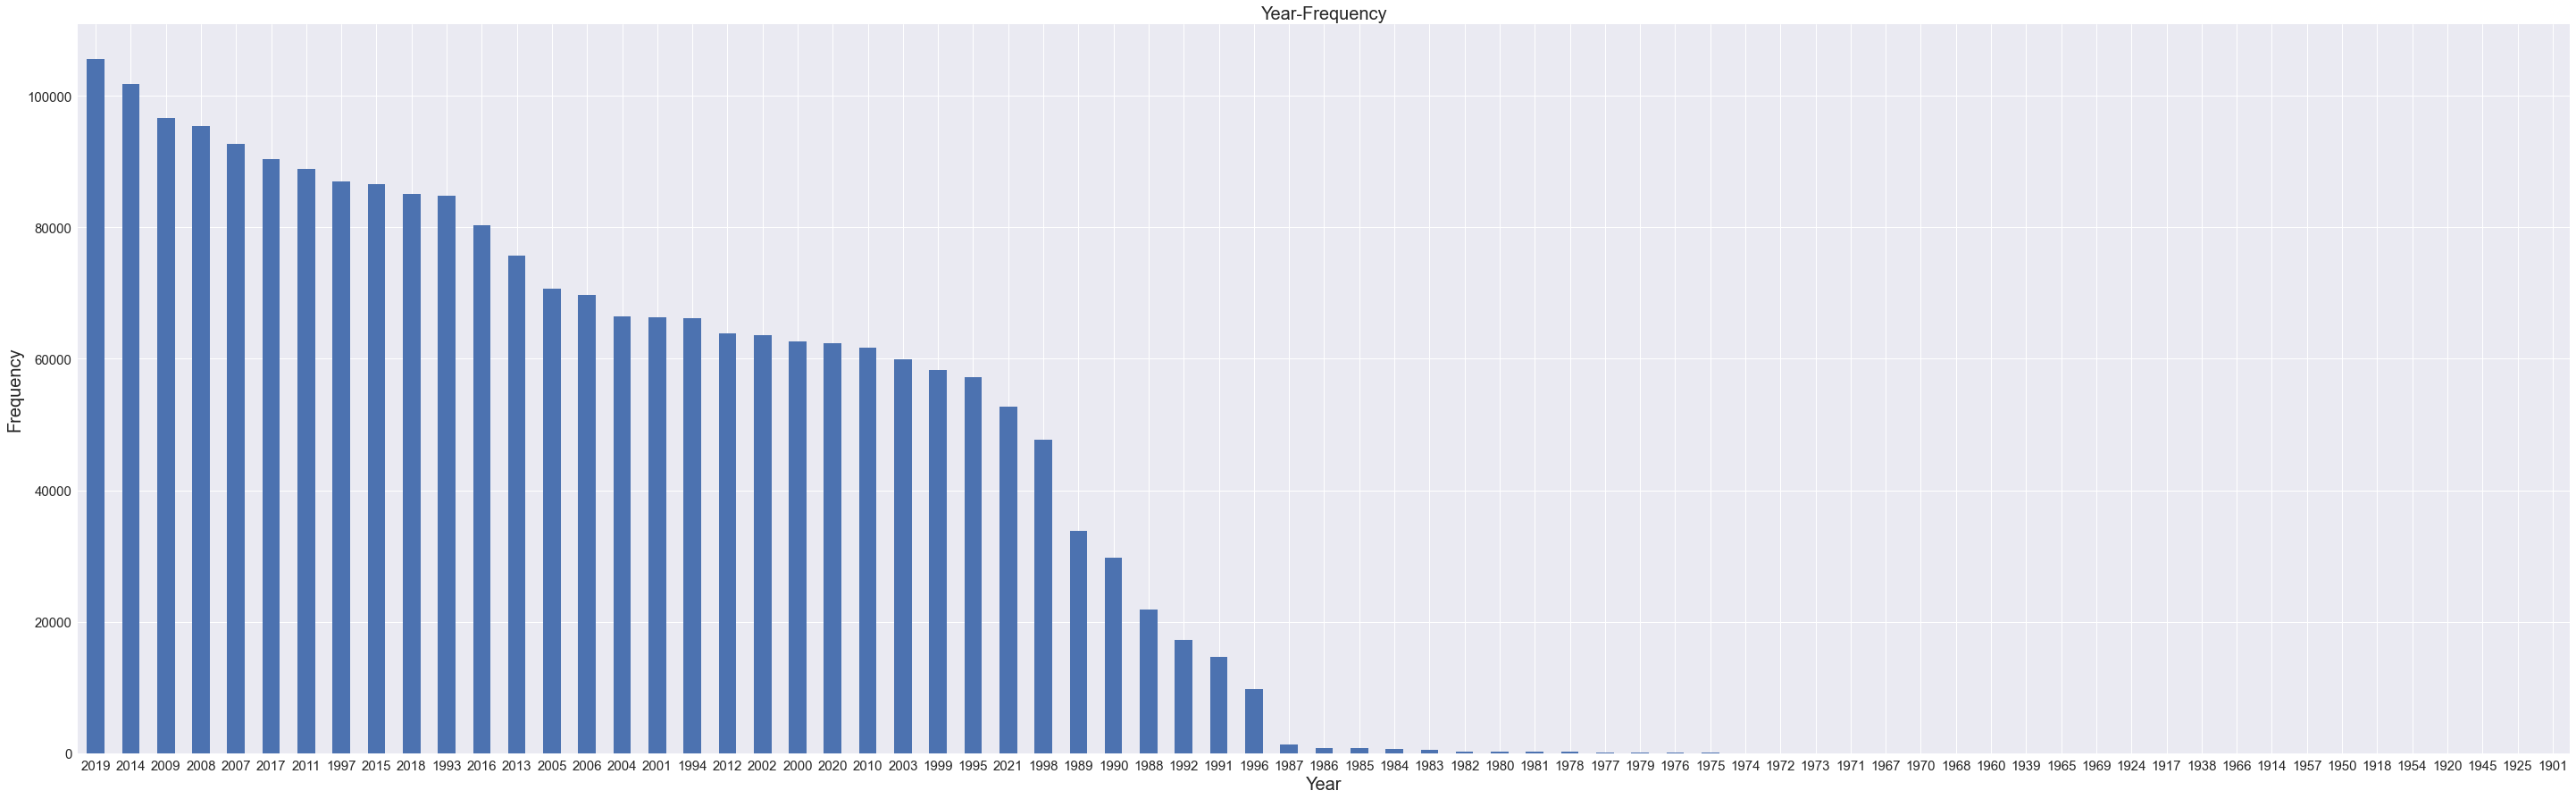

In [44]:
# After cleaning the data, show the years visualization.
draw(years, 'Year', 'Frequency', 'Year-Frequency', figsize=(50, 15))

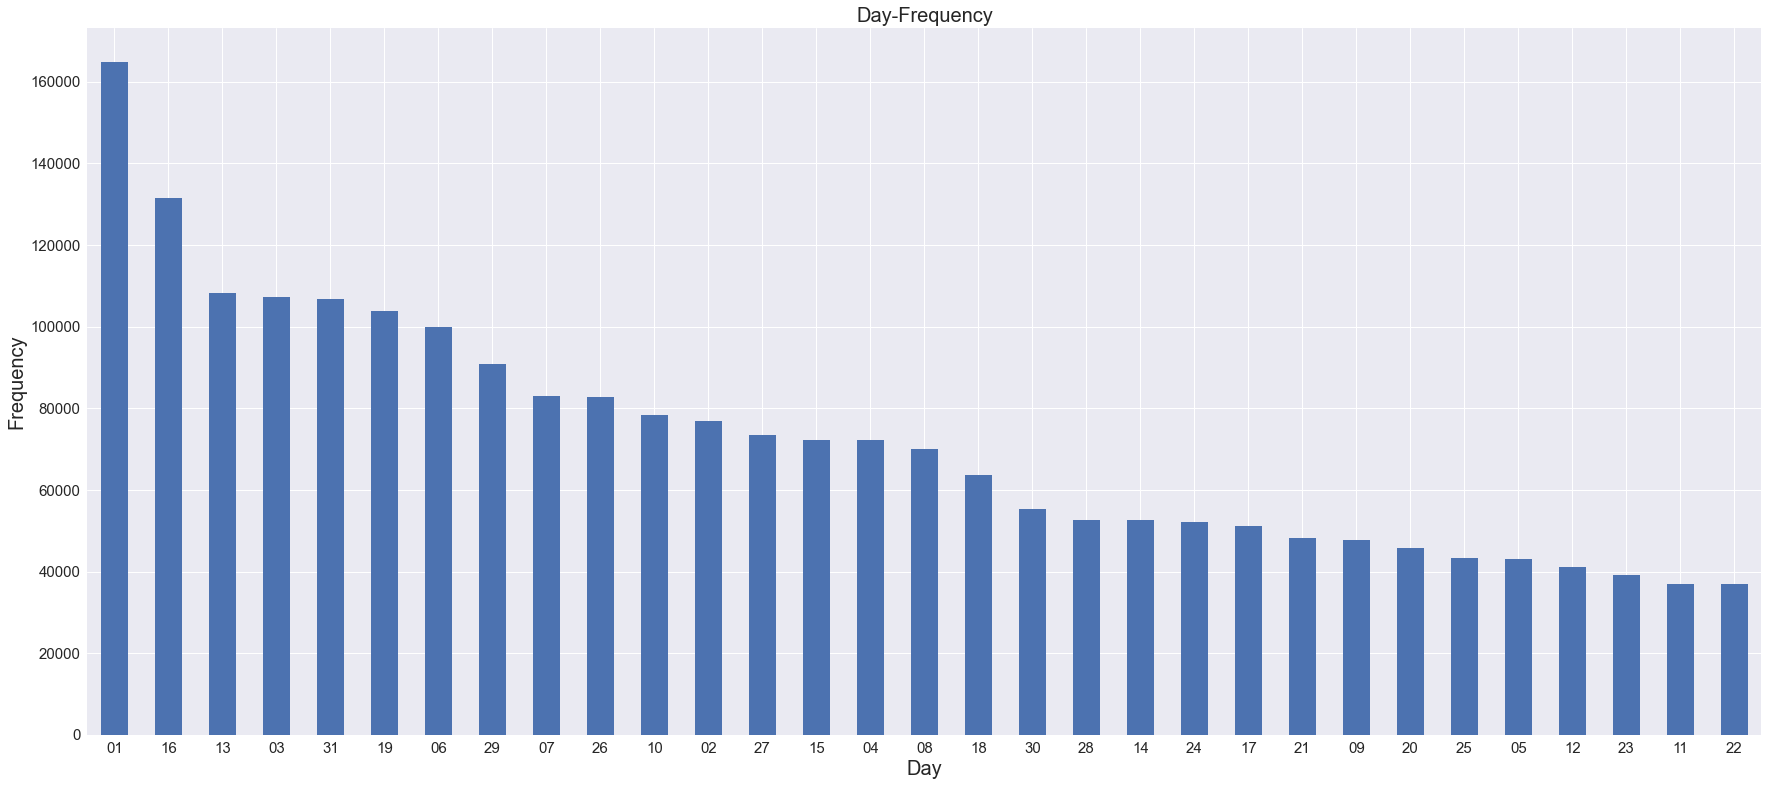

In [45]:
# After cleaning the data, show the days visualization.
draw(days, 'Day', 'Frequency', 'Day-Frequency')

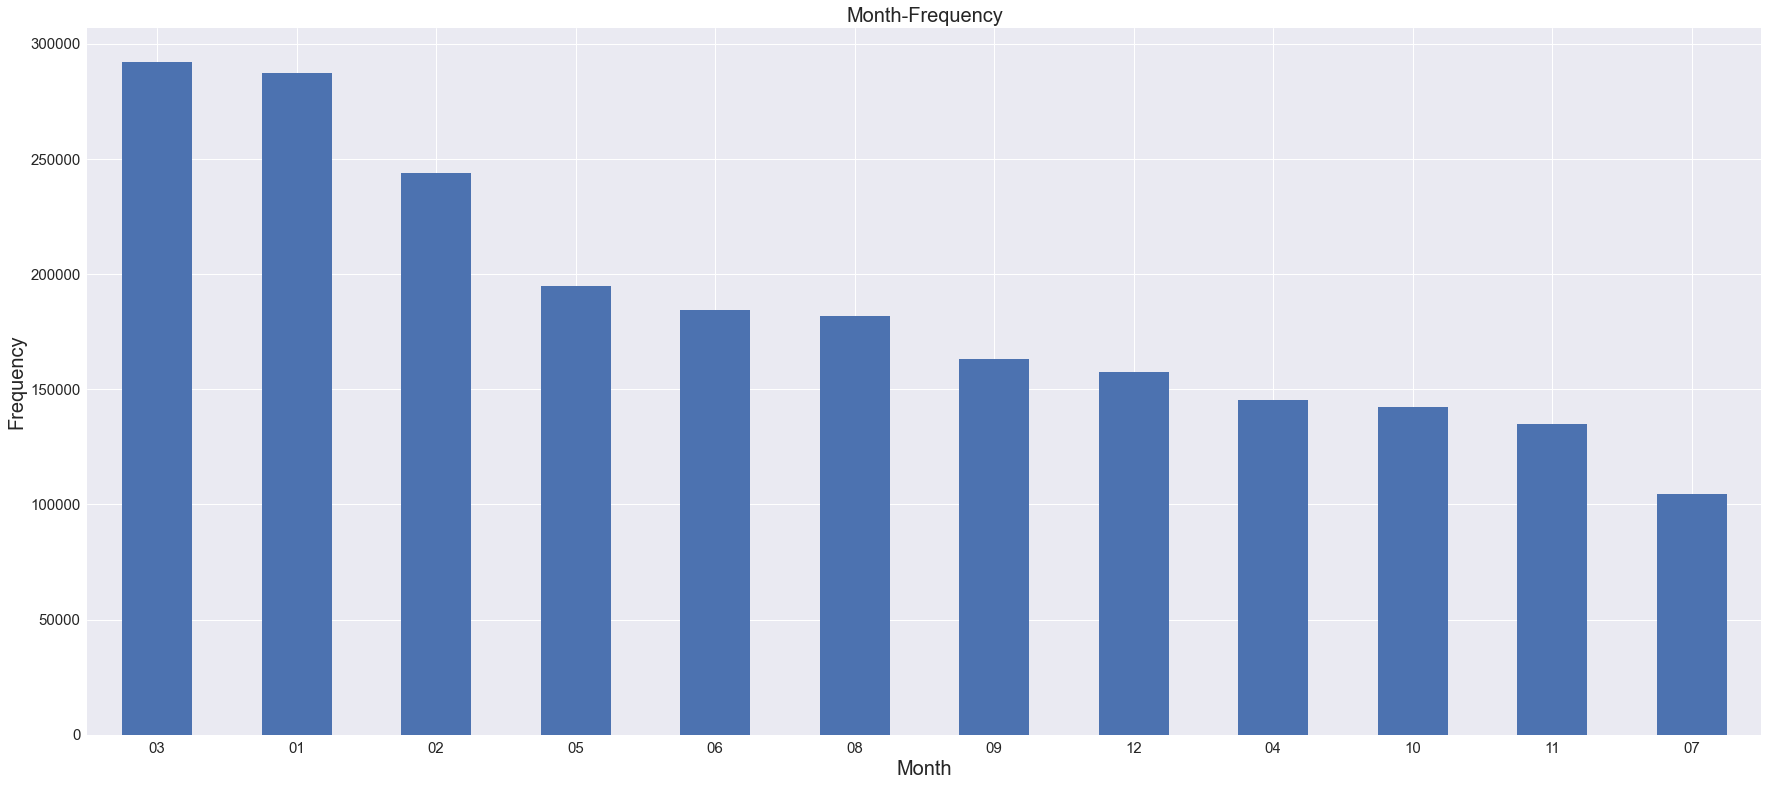

In [46]:
# After cleaning the data, show the months visualization.
draw(months, 'Month', 'Frequency', 'Month-Frequency')